In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import logit
from scipy.stats import gaussian_kde, qmc

In [2]:
data = pd.read_csv(r'D:\my work\Causal theory\pisa数据\2022\CY08MSP_STU_QQQ_processed_Official-variables_add-ICTSCHPRD.csv')
# 将 ICTUSE 进行离散化
data['ICTUSE'] = np.where(data['ICTUSE'] == 5, 1, 0)
data.head()

,AGE,GRADE,GENDER,IMMIG,REPEAT,STUDYHMW,EXPECEDU,RELATST,FAMSUP,SCHSUST,...,ICTREG,ICTDISTR,ICTEFFIC,PQSCHOOL,PAREXPT,Achievement,ICTSCHPRD,ICTSTUDY,ICTLEISURE,ICTUSE
0,15.83,-2,1,1,1,10,4,1.8580,-0.7468,1.5382,...,2.8904,12,0.007389,-0.000061,9,809.6578,1,0.495550,0.070993,1
1,16.33,0,1,1,0,10,9,1.7382,-0.5122,0.2241,...,2.0196,13,-0.235400,-0.000061,9,1429.1773,1,0.603467,0.070993,1
2,15.75,0,1,1,0,10,3,0.3802,-0.7563,-0.8256,...,2.8904,12,1.061300,-0.000061,9,1098.2520,1,1.321650,0.070993,1
3,15.75,0,2,1,0,10,3,1.2781,1.7495,-1.0391,...,0.8842,13,-0.824300,-0.000061,9,1057.3735,1,-0.521175,0.070993,1
4,15.92,0,1,1,0,10,8,0.8934,1.8705,1.3851,...,0.4704,4,0.526200,-0.000061,9,1565.6570,1,0.266275,0.070993,0


In [3]:
# 设置列名变量
Z = "ESCS"  # 这里你可以将 "ESCS" 更换为任何其他列名
num_bins = 5  # 或者10，根据你的选择
bin_labels = [f"bin_{i+1}" for i in range(num_bins)]  # 创建标签

# 划分数据
# data['Z_bin'], bins = pd.cut(data[Z], bins=num_bins, labels=bin_labels, retbins=True)  # 使用cut进行分组
# 使用 qcut 进行分组
data['Z_bin'] = pd.qcut(data[Z], q=num_bins, labels=bin_labels)

# 打印分组结果，查看每个分组的边界和计数
print(data['Z_bin'].value_counts())
data.head()

bin_3    51303
bin_1    51299
bin_2    51299
bin_4    51296
bin_5    51295
Name: Z_bin, dtype: int64


,AGE,GRADE,GENDER,IMMIG,REPEAT,STUDYHMW,EXPECEDU,RELATST,FAMSUP,SCHSUST,...,ICTDISTR,ICTEFFIC,PQSCHOOL,PAREXPT,Achievement,ICTSCHPRD,ICTSTUDY,ICTLEISURE,ICTUSE,Z_bin
0,15.83,-2,1,1,1,10,4,1.8580,-0.7468,1.5382,...,12,0.007389,-0.000061,9,809.6578,1,0.495550,0.070993,1,bin_1
1,16.33,0,1,1,0,10,9,1.7382,-0.5122,0.2241,...,13,-0.235400,-0.000061,9,1429.1773,1,0.603467,0.070993,1,bin_1
2,15.75,0,1,1,0,10,3,0.3802,-0.7563,-0.8256,...,12,1.061300,-0.000061,9,1098.2520,1,1.321650,0.070993,1,bin_1
3,15.75,0,2,1,0,10,3,1.2781,1.7495,-1.0391,...,13,-0.824300,-0.000061,9,1057.3735,1,-0.521175,0.070993,1,bin_1
4,15.92,0,1,1,0,10,8,0.8934,1.8705,1.3851,...,4,0.526200,-0.000061,9,1565.6570,1,0.266275,0.070993,0,bin_4


In [20]:
tmp_df = data[data['Z_bin'] == 'bin_5']
tmp_df['ESCS'].describe()

count    51295.000000
mean         1.142295
std          0.245593
min          0.827100
25%          0.954900
50%          1.096600
75%          1.274500
max          7.380000
Name: ESCS, dtype: float64

In [4]:
def estimate_conditional_probability(x_value, data, kde, num_trials=3, num_samples=4096): # 调整num_sample以平衡精度和性能
 
    probabilities = []
    for trial in range(num_trials):
        # 创建一个准随机数生成器
        sampler = qmc.Sobol(d=2, scramble=True)
        
        # 生成样本
        sample_w1_w2 = qmc.scale(sampler.random(n=num_samples), [data['ICTQUAL'].min(), data['ICTREG'].min()], [data['ICTQUAL'].max(), data['ICTREG'].max()])
        
        total_probability = 0
        total_weight = 0
        for w1, w2 in sample_w1_w2:
            density = kde.evaluate([w1, w2])[0]
            # 估计 Y = 1 的概率给定 X=x, W1=w1, W2=w2
            p_y_given_x_w1_w2 = model.predict(exog=dict(ICTSCHPRD=x_value, ICTQUAL=w1, ICTREG=w2))
            total_probability += p_y_given_x_w1_w2 * density
            total_weight += density
        probability = total_probability / total_weight
        probabilities.append(probability)
        print(f'第{trial+1}次trial的结果为{probability}')
    return np.mean(probabilities)  # 返回多次实验的平均概率

In [5]:
results = []
rows = []
for z_bin in bin_labels:
    bin_data = data[data['Z_bin'] == z_bin]
    total_rows = len(bin_data)
    print(f'当前数据集为{z_bin}，共有数据{total_rows}条')
    # 建立逻辑回归模型
    model = logit("ICTUSE ~ ICTSCHPRD + ICTQUAL + ICTREG", data=bin_data).fit()

    # 显示模型结果
    print(model.summary())
    # 提取 ICTQUAL 和 ICTREG 的数据
    W_values = bin_data[['ICTQUAL', 'ICTREG']].values.T
    # 建立核密度估计对象
    kde = gaussian_kde(W_values)
    
    p_y_x1 = estimate_conditional_probability(1, data=bin_data, kde=kde)
    print(f"P(ICTUSE=1 | do(ICTSCHPRD=1)): {p_y_x1}")
    p_y_x0 = estimate_conditional_probability(0, data=bin_data, kde=kde)
    print(f"P(ICTUSE=1 | do(ICTSCHPRD=0)): {p_y_x0}")
    results.append((p_y_x1, p_y_x0))
    rows.append(total_rows)

当前数据集为bin_1，共有数据51299条
Optimization terminated successfully.
         Current function value: 0.623973
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 ICTUSE   No. Observations:                51299
Model:                          Logit   Df Residuals:                    51295
Method:                           MLE   Df Model:                            3
Date:                Sun, 05 May 2024   Pseudo R-squ.:                 0.01818
Time:                        19:24:11   Log-Likelihood:                -32009.
converged:                       True   LL-Null:                       -32602.
Covariance Type:            nonrobust   LLR p-value:                1.002e-256
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4793      0.067     -7.143      0.000      -0.611      -0.348
ICTSCH

第1次trial的结果为0    0.895387
dtype: float64
第2次trial的结果为0    0.895366
dtype: float64
第3次trial的结果为0    0.895384
dtype: float64
P(ICTUSE=1 | do(ICTSCHPRD=1)): 0.8953787748454914
第1次trial的结果为0    0.495511
dtype: float64
第2次trial的结果为0    0.495541
dtype: float64
第3次trial的结果为0    0.495626
dtype: float64
P(ICTUSE=1 | do(ICTSCHPRD=0)): 0.49555949711590735


In [6]:
results, rows

([(0.6744239083188903, 0.36997741580461935),
  (0.7767669496205677, 0.48328849403038604),
  (0.8131034481110806, 0.4671248259679861),
  (0.8477796858427288, 0.4873525645671884),
  (0.8953787748454914, 0.49555949711590735)],
 [51299, 51299, 51303, 51296, 51295])

In [7]:
beta, gamma, theta, delta = 1, 0, 0, 0
evaluated_results = []
for p_y_x, p_y_x_prime in results:
    evaluated = (beta - theta) * p_y_x + (gamma - beta) * p_y_x_prime + theta
    evaluated_results.append(evaluated)
evaluated_results

[0.30444649251427097,
 0.29347845559018165,
 0.3459786221430945,
 0.3604271212755404,
 0.3998192777295841]

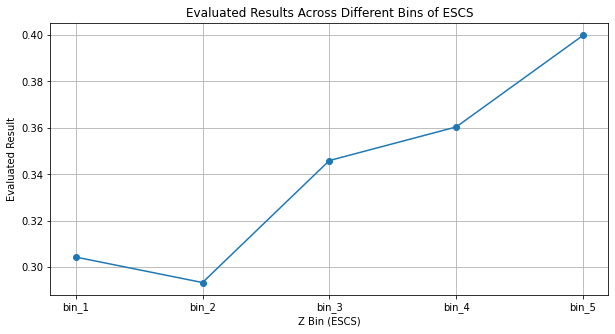

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(bin_labels, evaluated_results, marker='o')
plt.title('Evaluated Results Across Different Bins of ' + Z)
plt.xlabel('Z Bin (' + Z + ')')
plt.ylabel('Evaluated Result')
# plt.xticks(rotation=45)  # 旋转标签以获得更好的可视效果
plt.grid(True)
plt.show()

In [9]:
beta, gamma, theta, delta = 2, 1, -1, -2
evaluated_results = []
for p_y_x, p_y_x_prime in results:
    evaluated = (beta - theta) * p_y_x + (gamma - beta) * p_y_x_prime + theta
    evaluated_results.append(evaluated)
evaluated_results

[0.6532943091520516,
 0.8470123548313169,
 0.9721855183652557,
 1.0559864929609977,
 1.1905768274205673]

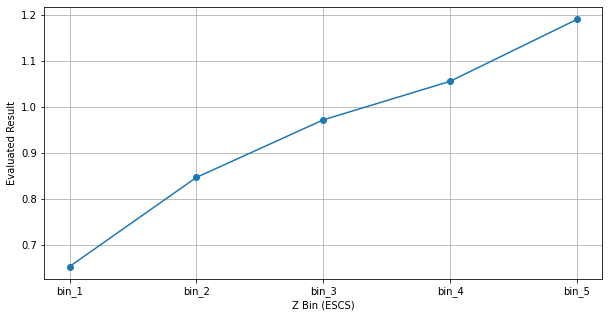

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(bin_labels, evaluated_results, marker='o')
# plt.title('Evaluated Results Across Different Bins of ' + Z)
plt.xlabel('Z Bin (' + Z + ')')
plt.ylabel('Evaluated Result')
# plt.xticks(rotation=45)  # 旋转标签以获得更好的可视效果
plt.grid(True)
plt.savefig('unit_selection.png', dpi=300)
plt.show()